# Steps Involved
1. we will collect the stock data
2. preprocess the data
3. create a stacked LSTM model
4. Predict the test data and plot the output
5. Predict the future 30 days and plot the output

In [ ]:
# Data Collection
import pandas_datareader as pdr
key="de024210a740b04261542d06ec2bff6b454086ae"

In [ ]:
df=pdr.get_data_tiingo("DOGEUSD",api_key=key)

In [ ]:
df.to_csv("AAPL.csv")

In [ ]:
df.tail()

close      high  ...  divCash  splitFactor
symbol  date                                           ...                      
DOGEUSD 2021-05-29 00:00:00+00:00  0.302806  0.317946  ...      0.0          1.0
        2021-05-30 00:00:00+00:00  0.301794  0.310787  ...      0.0          1.0
        2021-05-31 00:00:00+00:00  0.325573  0.329909  ...      0.0          1.0
        2021-06-01 00:00:00+00:00  0.370061  0.384783  ...      0.0          1.0
        2021-06-02 00:00:00+00:00  0.426632  0.444998  ...      0.0          1.0

[5 rows x 12 columns]

In [ ]:
df1=df.reset_index()["close"]

In [ ]:
df1

0       0.000205
1       0.000178
2       0.000178
3       0.000190
4       0.000206
          ...   
1513    0.302806
1514    0.301794
1515    0.325573
1516    0.370061
1517    0.426632
Name: close, Length: 1518, dtype: float64

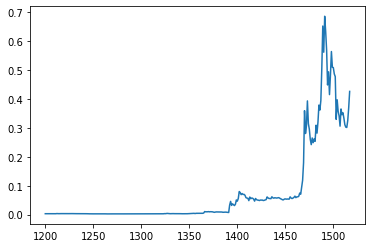

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1[1200:])

In [ ]:
#LSTM are sensitive to data so we apply min max scaler

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(1518, 1)

In [ ]:
# splitting the dataset
training_size = int(len(df1)*0.75)
test_size = len(df1)-training_size
train_data,test_data=df1[0:training_size],df1[training_size:len(df1)]

In [ ]:
# create array into dataset matrix
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [ ]:
X_train,y_train=create_dataset(train_data,time_step=100)
X_test,y_test=create_dataset(test_data,time_step=100)

In [ ]:
print(X_train.shape)

(1038, 100)


In [ ]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [ ]:
## creating the LSTM model
import tensorflow as tf
import keras
model=tf.keras.models.Sequential([
                                  tf.keras.layers.LSTM(50,return_sequences=True,input_shape=(100,1)),
                                  tf.keras.layers.LSTM(50,return_sequences=True),
                                  tf.keras.layers.LSTM(50),
                                  tf.keras.layers.Dense(1)
                                  ])
model.compile(loss="mean_squared_error",optimizer="Adam")

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=25,batch_size=64,verbose=1)

Epoch 1/25
17/17 [==============================] - 8s 227ms/step - loss: 3.7187e-05 - val_loss: 0.0624
Epoch 2/25
17/17 [==============================] - 3s 164ms/step - loss: 1.0091e-05 - val_loss: 0.0583
Epoch 3/25
17/17 [==============================] - 3s 164ms/step - loss: 7.5711e-06 - val_loss: 0.0561
Epoch 4/25
17/17 [==============================] - 3s 162ms/step - loss: 6.3628e-06 - val_loss: 0.0526
Epoch 5/25
17/17 [==============================] - 3s 161ms/step - loss: 6.1059e-06 - val_loss: 0.0474
Epoch 6/25
17/17 [==============================] - 3s 161ms/step - loss: 5.1861e-06 - val_loss: 0.0403
Epoch 7/25
17/17 [==============================] - 3s 164ms/step - loss: 4.1542e-06 - val_loss: 0.0267
Epoch 8/25
17/17 [==============================] - 3s 165ms/step - loss: 3.1385e-06 - val_loss: 0.0163
Epoch 9/25
17/17 [==============================] - 3s 161ms/step - loss: 3.4282e-06 - val_loss: 0.0182
Epoch 10/25
17/17 [==============================] - 3s 165ms/st

In [ ]:
 train_predict=model.predict(X_train)
 test_predict=model.predict(X_test)

In [ ]:
#transforming to orignal form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


In [ ]:
# calculate RMSE performance
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.002090990575623283

In [ ]:
math.sqrt(mean_squared_error(y_test,test_predict))


0.1289791273840775

In [ ]:
test_data.shape
n=test_data.shape[0]-n_steps

### Predicting the price

In [ ]:
x_input=test_data[n:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
from numpy import array
## stock prices for 30 days with data from 100 previous days
lst_output=[]
n_steps=100
i=0
days=30
while(i<days):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    
print(lst_output)

[0.4052951]
101
1 day input [0.0813585  0.07523484 0.07327529 0.07261239 0.07083934 0.07331472
 0.07296043 0.07327181 0.07094254 0.07187723 0.07394499 0.07525132
 0.08900881 0.08414234 0.08109195 0.08113335 0.08019491 0.08978612
 0.08454021 0.08278132 0.08493238 0.08404481 0.08327091 0.08456354
 0.08542495 0.0833779  0.07981501 0.07788944 0.07472008 0.07437673
 0.07829719 0.07898548 0.07787945 0.07853867 0.07837387 0.07792613
 0.08946356 0.08353236 0.08076791 0.08332068 0.08668139 0.09312427
 0.08545021 0.08957292 0.08938397 0.0925772  0.10866291 0.10281026
 0.13608046 0.17275326 0.26201927 0.52388266 0.40878077 0.44710725
 0.57313043 0.45853351 0.43031302 0.37880427 0.35275521 0.38626061
 0.3626059  0.38131055 0.36933405 0.45061485 0.4107507  0.46682081
 0.5523142  0.52695344 0.57535485 0.73868174 0.95061677 0.81858724
 1.         0.92429568 0.82920817 0.65363927 0.7199162  0.60493524
 0.70462256 0.82202611 0.74261078 0.74118379 0.7089748  0.69569205
 0.48007426 0.57877879 0.5207813  

## plotting

In [ ]:
day_new=np.arange(1,n_steps+1)
day_pred=np.arange(n_steps,n_steps+days)

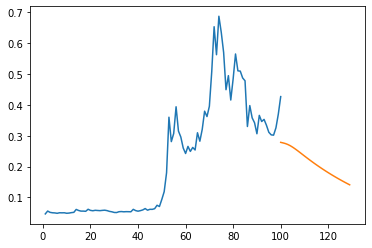

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1418:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

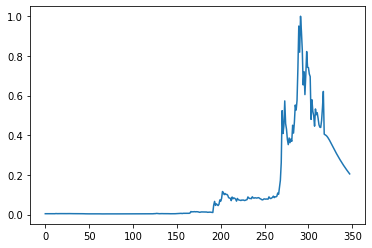

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

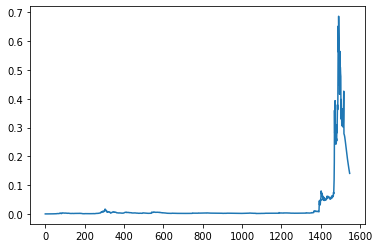

In [ ]:
plt.plot(df3)